In [1]:
from tensorflow import keras
import glob
import numpy as np
import cv2
import os
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [2]:
path_No = './data/brain_tumor_dataset_16mb/no/*'
path_Yes = './data/brain_tumor_dataset_16mb/yes/*'

tumor = []
no_tumor = []
random_state = 42

for file in glob.iglob(path_Yes):
    img = cv2.imread(file)      
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)        
    img = cv2.resize(img, (224, 224)) 
    tumor.append((img, 1))  

for file in glob.iglob(path_No):
    img = cv2.imread(file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    no_tumor.append((img, 0)) 
    
all_data = tumor + no_tumor


data = np.array([item[0] for item in all_data])
labels = np.array([item[1] for item in all_data])

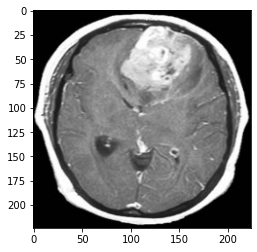

In [3]:
plt.imshow(data[30])


In [4]:
combined = list(zip(labels, data))
random.shuffle(combined)
shuffled_labels, shuffled_images = zip(*combined)

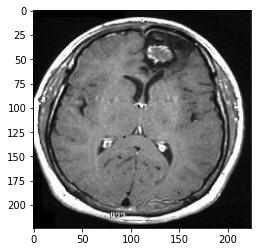

In [6]:
plt.imshow(shuffled_images[1])

In [7]:
shuffled_labels[1]


1

In [8]:
image_array = np.array(shuffled_images) 
labels_array = np.array(shuffled_labels)

In [9]:
#split the data

In [10]:
x_train, x_test, y_train, y_test = train_test_split(image_array, labels_array, test_size=0.1)


In [11]:
#data augmentation

In [12]:
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip('horizontal'),
    keras.layers.RandomRotation(0.3),
    keras.layers.RandomZoom(0.2)
])

In [14]:
callback = keras.callbacks.EarlyStopping(patience=50, monitor='loss')

In [15]:
#cnn

In [16]:
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = keras.layers.Rescaling(1./255)(inputs)
x = keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu')(x)
x = keras.layers.MaxPooling2D(pool_size=2)(x)
x = keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu')(x)
x = keras.layers.MaxPooling2D(pool_size=2)(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dropout(0.5)(x)
output = keras.layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs=inputs, outputs=output)

In [17]:
model.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [18]:
history = model.fit(x_train, y_train,epochs=20, validation_split=0.15, callbacks=[callback])

Epoch 1/20
6/6 [==============================] - 6s 859ms/step - loss: 0.9388 - accuracy: 0.5521 - val_loss: 0.4568 - val_accuracy: 0.8571
Epoch 2/20
6/6 [==============================] - 5s 796ms/step - loss: 0.5076 - accuracy: 0.8021 - val_loss: 0.3844 - val_accuracy: 0.8571
Epoch 3/20
6/6 [==============================] - 6s 978ms/step - loss: 0.4564 - accuracy: 0.8021 - val_loss: 0.3101 - val_accuracy: 0.9143
Epoch 4/20
6/6 [==============================] - 5s 850ms/step - loss: 0.4013 - accuracy: 0.8281 - val_loss: 0.3212 - val_accuracy: 0.8571
Epoch 5/20
6/6 [==============================] - 5s 859ms/step - loss: 0.3584 - accuracy: 0.8594 - val_loss: 0.2913 - val_accuracy: 0.8857
Epoch 6/20
6/6 [==============================] - 5s 836ms/step - loss: 0.3079 - accuracy: 0.8802 - val_loss: 0.2859 - val_accuracy: 0.8857
Epoch 7/20
6/6 [==============================] - 5s 852ms/step - loss: 0.2053 - accuracy: 0.9531 - val_loss: 0.2636 - val_accuracy: 0.8571
Epoch 8/20
6/6 [====

In [20]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                        

In [22]:
model.evaluate(x_test, y_test)

1/1 [==============================] - 0s 152ms/step - loss: 0.3526 - accuracy: 0.8462


[0.3525778651237488, 0.8461538553237915]

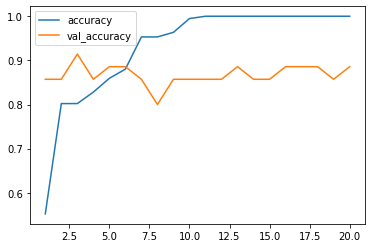

In [23]:
my_dict = history.history
number = range(1, len(my_dict['loss']) + 1)
accuracy = my_dict['accuracy']
val_accuracy = my_dict['val_accuracy']
plt.plot(number, accuracy, label='accuracy')
plt.plot(number, val_accuracy, label='val_accuracy')
plt.legend()

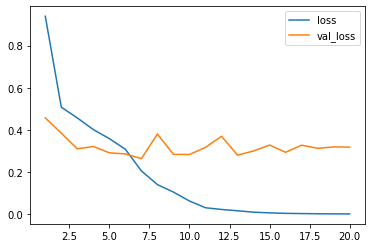

In [24]:
loss = my_dict['loss']
val_loss = my_dict['val_loss']
plt.plot(number, loss, label='loss')
plt.plot(number, val_loss, label='val_loss')
plt.legend()

In [27]:
#accuracy prediction
accuracy_score = model.evaluate(x_test, y_test)[1]  
print("Accuracy:", accuracy_score)


1/1 [==============================] - 0s 150ms/step - loss: 0.3526 - accuracy: 0.8462
Accuracy: 0.8461538553237915


In [29]:
from sklearn.metrics import f1_score
y_pred = model.predict(x_test)  # Adjust X_test with your test data
f1_score_value = f1_score(y_test, y_pred.round())
print("F1 Score:", f1_score_value)


1/1 [==============================] - 0s 288ms/step
F1 Score: 0.8888888888888888


In [30]:
from sklearn.metrics import recall_score
sensitivity_score = recall_score(y_test, y_pred.round())
print("Sensitivity:", sensitivity_score)


Sensitivity: 0.8888888888888888


In [31]:
from sklearn.metrics import roc_auc_score
roc_score = roc_auc_score(y_test, y_pred)
print("ROC Score:", roc_score)


ROC Score: 0.9583333333333333


In [36]:
print("functional?")

functional?


In [34]:
# Assuming you have original and predicted values
nae_score = np.mean(np.abs(y_test - y_pred)) / np.mean(np.abs(y_test))
print("Normalized Absolute Error (NAE):", nae_score)


Normalized Absolute Error (NAE): 0.6128715012905794


In [41]:
# # Assuming you have original and predicted images
# from skimage.metrics import peak_signal_noise_ratio
# psnr_score = peak_signal_noise_ratio(original_image, predicted_image)
# print("PSNR Score:", psnr_score)
